In [4]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import math
import numpy as np

In [5]:
#First Dataframe ##########################
url_1 = "http://www.jmulti.de/download/datasets/e2.dat"
df_1  = pd.read_csv(url_1).iloc[:,:1]
df_1 = df_1.iloc[:,0].str.split()[7:]
df_fix = pd.DataFrame(columns = ["US Fixed Investment (1947-1974)", "Quaterly Changes"])
df_fix["US Fixed Investment (1947-1974)"] = [float(element[0]) for element in df_1]
df_fix["Quaterly Changes"] = [float(element[1]) for element in df_1]
#Second Dataframe ##########################
url_2 = "http://www.jmulti.de/download/datasets/e3.dat"
df_2  = pd.read_csv(url_1).iloc[:,:1]
df_2 = df_2.iloc[:,0].str.split()[8:]
df_yield = pd.DataFrame()
df_yield["Quaterly German Nominal GDP"] = [float(element[0]) for element in df_2]
#Third Dataframe ##########################
url_3 = "http://www.jmulti.de/download/datasets/NP_xetradax_returns100.dat"
df_3  = pd.read_csv(url_3, on_bad_lines='skip').iloc[:,:1]
df_3 = df_3.iloc[:,0].str.split()[7:]
df_stock = pd.DataFrame()
df_stock["DAX Daily Returns"] = [float(element[0]) for element in df_3]
#Fourth Dataframe: Disposable income ##########################
url_4 = "http://www.jmulti.de/download/datasets/e4.dat"
df_4  = pd.read_csv(url_4, on_bad_lines='skip').iloc[:,:1]
df_4 = df_4.iloc[:,0].str.split()[7:]
df_disposable = pd.DataFrame()
df_disposable["Quaterly Per Capital Disposible Income"] = [float(element[0]) for element in df_4]

### Introduction

We will briefly discuss __autoregressive processes (AR)__. In addition we will consider __moving averages (MA)__ and __mixed autorregressive moving average (ARMA)__ models. Furthermore, we will consider __autoregressive integrated moving average (ARIMA) processes and seasonal variants__.

To simplify it is useful to use the lag operator ($L$).

### 1. Autoregressive Processes

An AR process of order p ($AR(p)$) may be written as:

$$y_t = \alpha_1y_{t-1} + \ldots + \alpha_py_{t-p} + u_t$$

where $u_t$ is an unobservable zero mean withe noise process with time invariant variance $\mathbb{E}(u_t^2) = \sigma_u^2$ and the $\alpha_i$ are fixed coefficients.

In terms of the lag operator ($Ly_t = y_{t-1}$):

$$\left(1 - \alpha_1L - \ldots - \alpha_pL^p\right)y_t = u_t \space \text{ or } \space \alpha(L)y_t = u_t$$

In the case the process it is stable, it can be represented as the __weighted sum of past errors__. 

$$y_t = \alpha{L}^{-1}u_t =	\phi(L)u_t = u_t + \sum_{j=1}^{+\infty}\phi_ju_{t-j}$$


#### Statistics of AR processes

- Mean: 0
- Variance: $\sigma_y^2 = \gamma_0 = \sigma_u^2\sum_{j = 0}^{j = \infty}\phi_j^2$
- Autocovariance: $\gamma_h = \sigma_u^2\sum_{j = 0}^{j = \infty}\phi_j  \phi_{j+h} $
- Spectral Density: $f_y(\lambda) = (2\pi)^{-1}\sigma_u^2\lvert\alpha(e^{i\lambda})\rvert^{-2}$

In [6]:
def ar1_process(alpha, sigma, n):
  # Initialize the time series with a random normal value
  X = [np.random.normal(0, sigma)]
  
  # Generate the remaining n-1 values of the time series
  for t in range(1, n):
    X.append(alpha * X[t-1] + np.random.normal(0, sigma))
    
  return np.array(X)

In [7]:
def spectral_density(time_series, lambda_, truncation_period):
    weights = [1 - j/truncation_period for j in range(truncation_period)]
    autocorrelations = []
    for j in range(truncation_period):
        autocorrelations.append(time_series.autocorr(lag=j))
    output = 1/(2*math.pi)*(weights[0]*autocorrelations[0] + 2*sum([weights[j]*autocorrelations[j]*math.cos(lambda_*j) for j in range(1, truncation_period)]))
    return output

<AxesSubplot:>

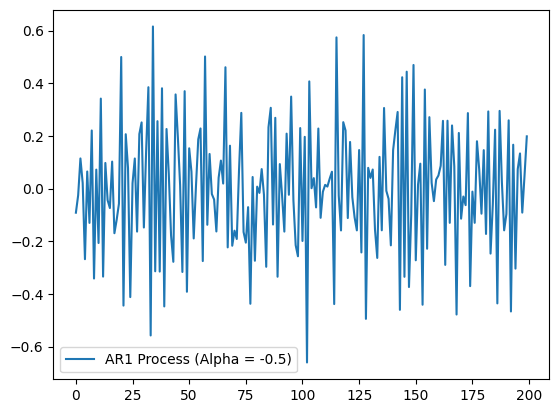

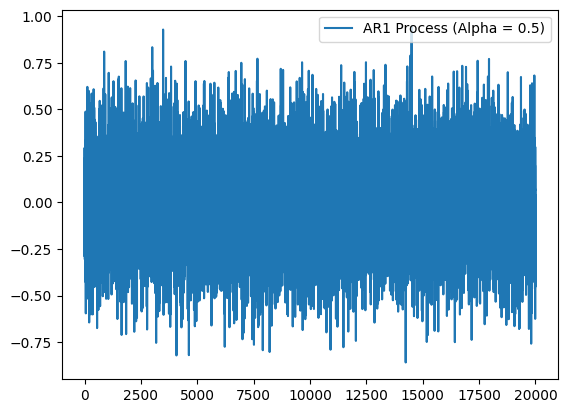

In [8]:
# Generate a realization of an AR(1) process with alpha = 0.8 and sigma = 1
df = pd.DataFrame(ar1_process(-0.5, 0.2, 200), columns = ['AR1 Process (Alpha = -0.5)'])
df_pos = pd.DataFrame(ar1_process(0.5, 0.2, 20000), columns = ['AR1 Process (Alpha = 0.5)'])
df.plot()
df_pos.plot()

[]

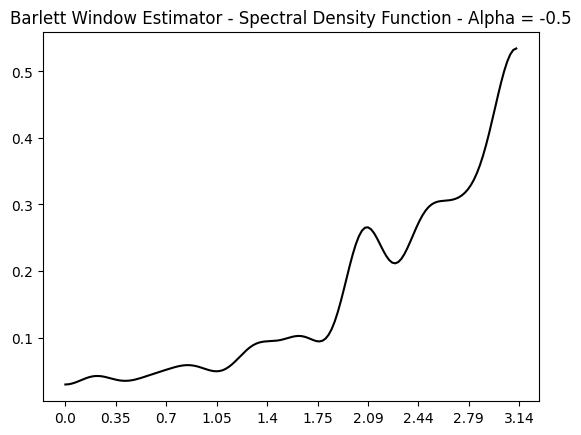

In [9]:
spectre = [spectral_density(df.squeeze(), element, 20) for element in np.linspace(0, math.pi, num = 150)]
spectre_pos = [spectral_density(df_pos.squeeze(), element, 20) for element in np.linspace(0, math.pi, num = 150)]
plt.plot(spectre, color='black')
xi = np.linspace(0, math.pi, num = 10)
xi = [round(element, 2) for element in xi]
plt.xticks(np.linspace(0, 150, num = 10), xi)
plt.title("Barlett Window Estimator - Spectral Density Function - Alpha = -0.5")
plt.plot()


[]

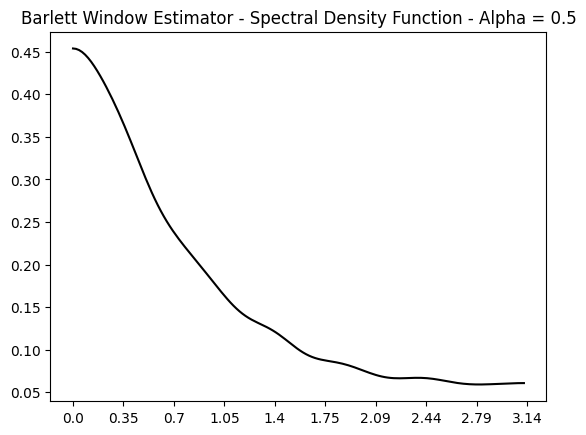

In [10]:
spectre_pos = [spectral_density(df_pos.squeeze(), element, 20) for element in np.linspace(0, math.pi, num = 150)]
plt.plot(spectre_pos, color='black')
xi = np.linspace(0, math.pi, num = 10)
xi = [round(element, 2) for element in xi]
plt.xticks(np.linspace(0, 150, num = 10), xi)
plt.title("Barlett Window Estimator - Spectral Density Function - Alpha = 0.5")
plt.plot()

- Cuando el alpha es positivo, los elementos consecutivos evolucionan hacia el mismo sentido, pequenas frecuencias van a contribuir a la variabilidad total de la serie de forma mas determinante. 

- Sin embargo, si la autocovarianza es negativa, un punto por encima de la media vendra seguido de un punto por debajo de esta. Por lo tanto en frecuencias pequenas no hay casi varianza. La variabilidad de esta serie esta en frecuencias mayores.

#### AR(p) processes and unit root

If, for an $AR(p)$ process $\alpha(z)$ has a root for $z = 1$ the operator in the AR process can be factored as: 

$$\alpha(L) = (1 - \alpha_1 L - \ldots - \alpha^{p-1}L^{p-1})(1-L)$$

If we replace $1 - L$ by $\Delta$:

$$u_t = (1 - \alpha_1^{*} L - \ldots - \alpha_{p-1}^{*}L^{p-1})\Delta y_t$$

Which is an $AR(p_1)$ model for the first difference of $y_t$. If this models has all of his roots outside the complex unit circle, $\Delta y_t$ is stationary. And $y_t$ is $I(1)$. Otherwise, if it has another unit root, we repeat the process. 



### 2. Finite-Order Moving Average Processes

The process $y_t$ can be represented as: 
$$y_t = u_t + m_1u_{t-1} + \ldots + m_qu_{t-q}$$

Where $u_t$ is again a zero mean white noise, the process is called __moving average of order q (MA(q))__.

Can be written more compactly as: 
$$y_t = (1 + m_1L + \ldots + m_qL^{q})u_t \space \text{or }\space y_t = m(L)u_t$$

Uniqueness of the representation is guaranteed if the characteristic equation has no unit roots, then the process is called __invertible__. In that case it has an infinite order AR representation: 
$$m(L)^{-1}y_t = \alpha(L)y_t = y_t - \sum_{j=1}^{\infty}\alpha_jy_{t-j} = u_t $$

*Exercise: Try to look for conditions on $m_1$ for MA(1) process being invertible. (pg.25)*



#### Plotting MA processes

In [11]:
def ma1_process(n, m1, sigma):
  # Initialize the time series and the error term
  time_series = np.zeros(n)
  white_noise = np.random.normal(0, sigma, n)
  
  # Generate the MA(1) process
  for i in range(1, n):
    time_series[i] = m1 * white_noise[i-1] + white_noise[i]
    
  return time_series

<AxesSubplot:>

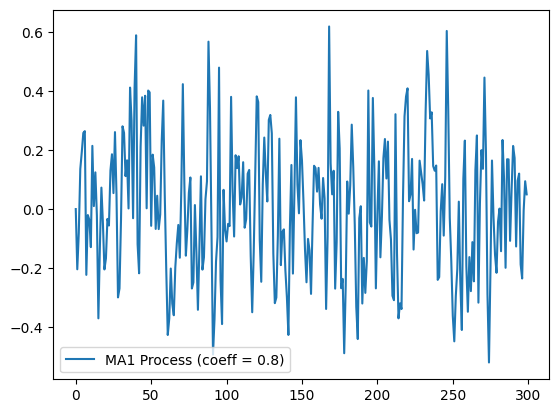

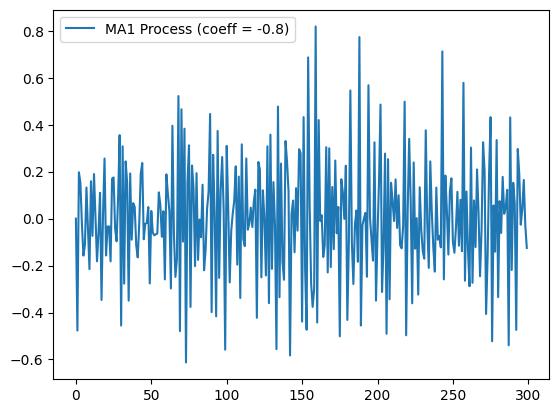

In [16]:
df_ma = pd.DataFrame(ma1_process(300, 0.8, 0.2), columns = ['MA1 Process (coeff = 0.8)'])
df_ma_neg = pd.DataFrame(ma1_process(300, -0.8, 0.2), columns = ['MA1 Process (coeff = -0.8)'])
df_ma.plot()
df_ma_neg.plot()

#### Statistics of an MA process

- $\mathbb{E}(y_t) = 0$
- $\sigma_y = \sigma_u^2 \sum_{j=0}^{q}m_j^2$
- $\gamma_h = \sigma_u^2 \sum_{j=0}^{q-h}m_jm_{j+h}$
- $f_y(\lambda) = (2\pi)^{-1}\sigma_u^2 \lvert m(e^{i\lambda})\rvert^2$

### 3. ARMA Processes

#### Definition

A mixed __ARMA process__ $y_t$ with AR order $p$ and MA order $q$ (__ARMA(p, q)__) has the representation: 

$$y_t = \alpha_1y_{t-1} + \ldots + \alpha_p y_{t - p} + u_t+m_1u_{t-1} + \ldots + m_qu_{t-q}$$

In compact lag operator notation, we have: 

$$\alpha(L)y_t = m(L)u_t$$

__*Look at page 27 of the book for stable, invertible, stationnary process*__

#### Properties

- AR Properties: The process is stable and stationnary if $\alpha(z) \neq 0$ for $\lvert z \rvert \leq 1$. If the process is stable, it has an infinite MA representation from which the autocorrelations can be obtained. 
- MA Properties: The process is invertible if $ m(z) \neq 0$ for  $\lvert z \rvert \leq 1$.
- For ARMA processes the autocorrelations and partial autocorrelations do not have a cutoff point but taper off to zero gradually. 

### 4. ARIMA Processes

#### Definition

A stochastic process $y_t$ is called an __ARIMA (p, d, q)__ process if: 

- It is $I(d)$
- The $d$ times differenced process has an ARMA(p, q) representation: $\Delta^dy_t \sim ARMA(p,q)$.

#### Remark: Modelling a Seasonal Process

*Puedes utilizar dependencia con factores anteriores pero pasar directamente a los de la "season asociada" (__use season powers of the lag operator__). Por ejemplo, si nuestro proceso tiene $s = 4$ (datos cuatrimestrales):* 

$$(1 - \alpha_{41}L^4)(1 - \alpha_1L)y_t = u_t \Leftrightarrow y_t = \alpha_1 y_{t-1} + \alpha_{41}y_{t-4} - \alpha_1 \alpha_{41}y_{t-5} + u_t$$

*Aqui por ejemplo vemos una dependencia de $y_t$ con el valor anterior (Lag operator sin potencia alguna) y con el valor cuatro meses atras (valor de la season asociada, lag operator con potencia $s = 4$)*.

Thus, although the AR part involves five lags, it can be represented with two parameters. 

### 5. Autoregressive Conditional Heteroskedasticity (ARCH processes)

So far we have focused on modeling __the conditional mean of the DGP of a time series given the past of the process__. For example if $u_t$ is a white noise process of independent random variables and $y_t$ is an AR(p) process, then: 
$$\mathbb{E}(y_t \vert y_{t-1}, \ldots) = \alpha_1 y_{t-1} + \ldots \alpha_p y_{t-p}$$

*Basicamente, con este tipo de modelos lo que modelizas es lo que esperas obtener dadas observaciones pasadas sumado a un error (white noise process).*

But, for series with __large outliers and volatility clustering__ (like for example VIX index or DAX daily returns), __the conditional second moments may have an important structure as well.__

*Si tienes varianzas distintas y concentradas (pensar por ejemplo a nivel economico una epoca convulsa para los mercados), puede ser interesante modelizar el segundo momento de la serie temporal (quizas incrementando la varianza de los residuos)*.

__By now, the acronym ARCH stands for a wide range of models for changing conditional volatility__.

#### 5.1 Definition (ARCH processes)

Consider the univariate AR(p) model. The residuals $u_t$ of this model are said to __follow an autoregressive coniditionally heteroskedastic process of order $q$ (ARCH(q))__ if the conditional distribution $u_t$ given its past $\Omega_{t-1} = \{u_{t-1},u_{t-2}, \ldots \}$, has zero mean and the conditional variance is: 

$$\sigma_t^2 = \mathbb{V}(u_t \vert \Omega_{t-1}) = \mathbb{E}(u_t^2\vert \Omega_{t-1}) = \gamma_0 + \gamma_1u_{t-1}^2 + \ldots \gamma_qu_{t-q}^2$$

*Este modelo puede ser util para series temporales que pueden seguir un tipo de procesos como los descritos anteriormente pero __residuos muestren una variabilidad en su varianza__*

#### 5.2 Definition (GARCH processes)


In the __Generalized ARCH process (GARCH (q, n))__ conditional variances are given by: 

$$\sigma_t^2 = \gamma_0 + \gamma_1u_{t-1}^2 + \ldots \gamma_qu_{t-q}^2 + \beta_1 \sigma_{t-1}^2 + \ldots + \beta_n \sigma_{t-n}^2$$

### 6. Deterministic terms

So far we have considered __purely stochastic processes with zero mean__. We have to allow for a non-zero mean term. To model this mean, we may have to add a polynomial trend term or seasonal dummy variables. 

__We will do so by adding such deterministic term to the stochastic part of the process__. 

We will assume that the obsevable process: 

$$y_t = x_t + \mu_t$$

- $x_t$ is a purely stochastic process. 
- $\mu_t$ is a purely deterministic part.

#### 6.1 Example of $\mu_t$
- $\mu_t = \mu$
- $\mu_t = \mu_0 + \mu_1 t$
- $\mu_t = \mu_0 + \mu_1 t + \delta_1 s_{1t} + \delta_q s_{qt}$

Here $s_{it}$ is a dummy variable having value $1$ if $t$ refers to the $i^{th}$ season, otherwise is $0$